In [10]:
# 🧀 Climate & Cheese in Canada: Enhanced Data Analysis
# This notebook provides a comprehensive analysis of how climate affects cheese production in Canada
# by combining the Canadian Cheese Directory with historical provincial temperature data.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [11]:

# =============================================================================
# 📊 DATA LOADING AND EXPLORATION
# =============================================================================
print("\n📊 Loading and exploring data...")
cheese_df = pd.read_csv('cheese_data.csv')
temp_df = pd.read_csv('Canada_Temperature_Data.csv')

print(f"\nCheese Data Shape: {cheese_df.shape}")
print(f"Temperature Data Shape: {temp_df.shape}")



📊 Loading and exploring data...

Cheese Data Shape: (1042, 13)
Temperature Data Shape: (1357283, 7)


"""
Canada’s culinary heritage includes a surprising diversity of cheeses—ranging from firm, aged varieties to soft, creamy delights.
This notebook investigates how climate—especially temperature—shapes cheese production across Canada.
With over 1,000 cheese records and more than 1.3 million climate entries, we explore whether colder provinces tend to produce firmer cheese,
and how climate variability links to cheese diversity.
"""

# =============================================================================
# 🔍 KEY QUESTIONS
# =============================================================================
"""
1. Do colder provinces prefer firmer cheeses?
2. Does temperature variability influence the diversity of cheese types?
3. Can climate categories (Cold, Moderate, Warm) help explain regional specialization?
"""

In [12]:
# =============================================================================
# 🧹 CLEANING AND FEATURE ENGINEERING
# =============================================================================
print("\n🧹 Cleaning and preparing data...")
cheese_df_clean = cheese_df.copy()
for col in ['FlavourEn', 'CharacteristicsEn', 'CategoryTypeEn', 'MilkTreatmentTypeEn']:
    cheese_df_clean[col] = cheese_df_clean[col].fillna('Unknown')

def categorize_texture(moisture):
    if pd.isna(moisture): return 'Unknown'
    elif moisture >= 60: return 'Soft'
    elif moisture >= 40: return 'Semi-firm'
    else: return 'Firm'
cheese_df_clean['Texture'] = cheese_df_clean['MoisturePercent'].apply(categorize_texture)

# Clean temperature data
temp_df_clean = temp_df[temp_df['Year'] >= 2000].copy()
avg_temp_by_province = (temp_df_clean.groupby('Prov')['Tm']
                       .agg(['mean', 'std', 'min', 'max'])
                       .reset_index()
                       .rename(columns={
                           'Prov': 'ManufacturerProvCode',
                           'mean': 'AvgTemperature',
                           'std': 'TempVariability',
                           'min': 'MinTemperature',
                           'max': 'MaxTemperature'
                       }))
print(f"✓ Processed temperature data for {len(avg_temp_by_province)} provinces")



🧹 Cleaning and preparing data...
✓ Processed temperature data for 13 provinces


In [13]:
# Feature engineering
print("\n⚙️ Engineering features...")
cheese_stats = cheese_df_clean.groupby('ManufacturerProvCode').agg({
    'CheeseId': 'count',
    'MoisturePercent': ['mean', 'std', 'median'],
    'FatLevel': lambda x: x.nunique(),
    'CheeseName': 'nunique',
    'FlavourEn': lambda x: len(set(x.dropna())),
    'Texture': lambda x: x.value_counts().to_dict()
}).reset_index()
cheese_stats.columns = [
    'ManufacturerProvCode', 'TotalCheeses', 'AvgMoisture', 'MoistureStd',
    'MedianMoisture', 'UniqueFatLevels', 'UniqueCheeseNames', 'UniqueFlavours', 'TextureDistribution'
]
cheese_stats['DominantTexture'] = cheese_stats['TextureDistribution'].apply(
    lambda d: max(d.items(), key=lambda x: x[1])[0] if isinstance(d, dict) and d else 'Unknown')

merged_data = pd.merge(cheese_stats, avg_temp_by_province, on='ManufacturerProvCode', how='inner')
print(f"✓ Created merged dataset with {len(merged_data)} provinces")



⚙️ Engineering features...
✓ Created merged dataset with 10 provinces



📈 Performing exploratory data analysis...


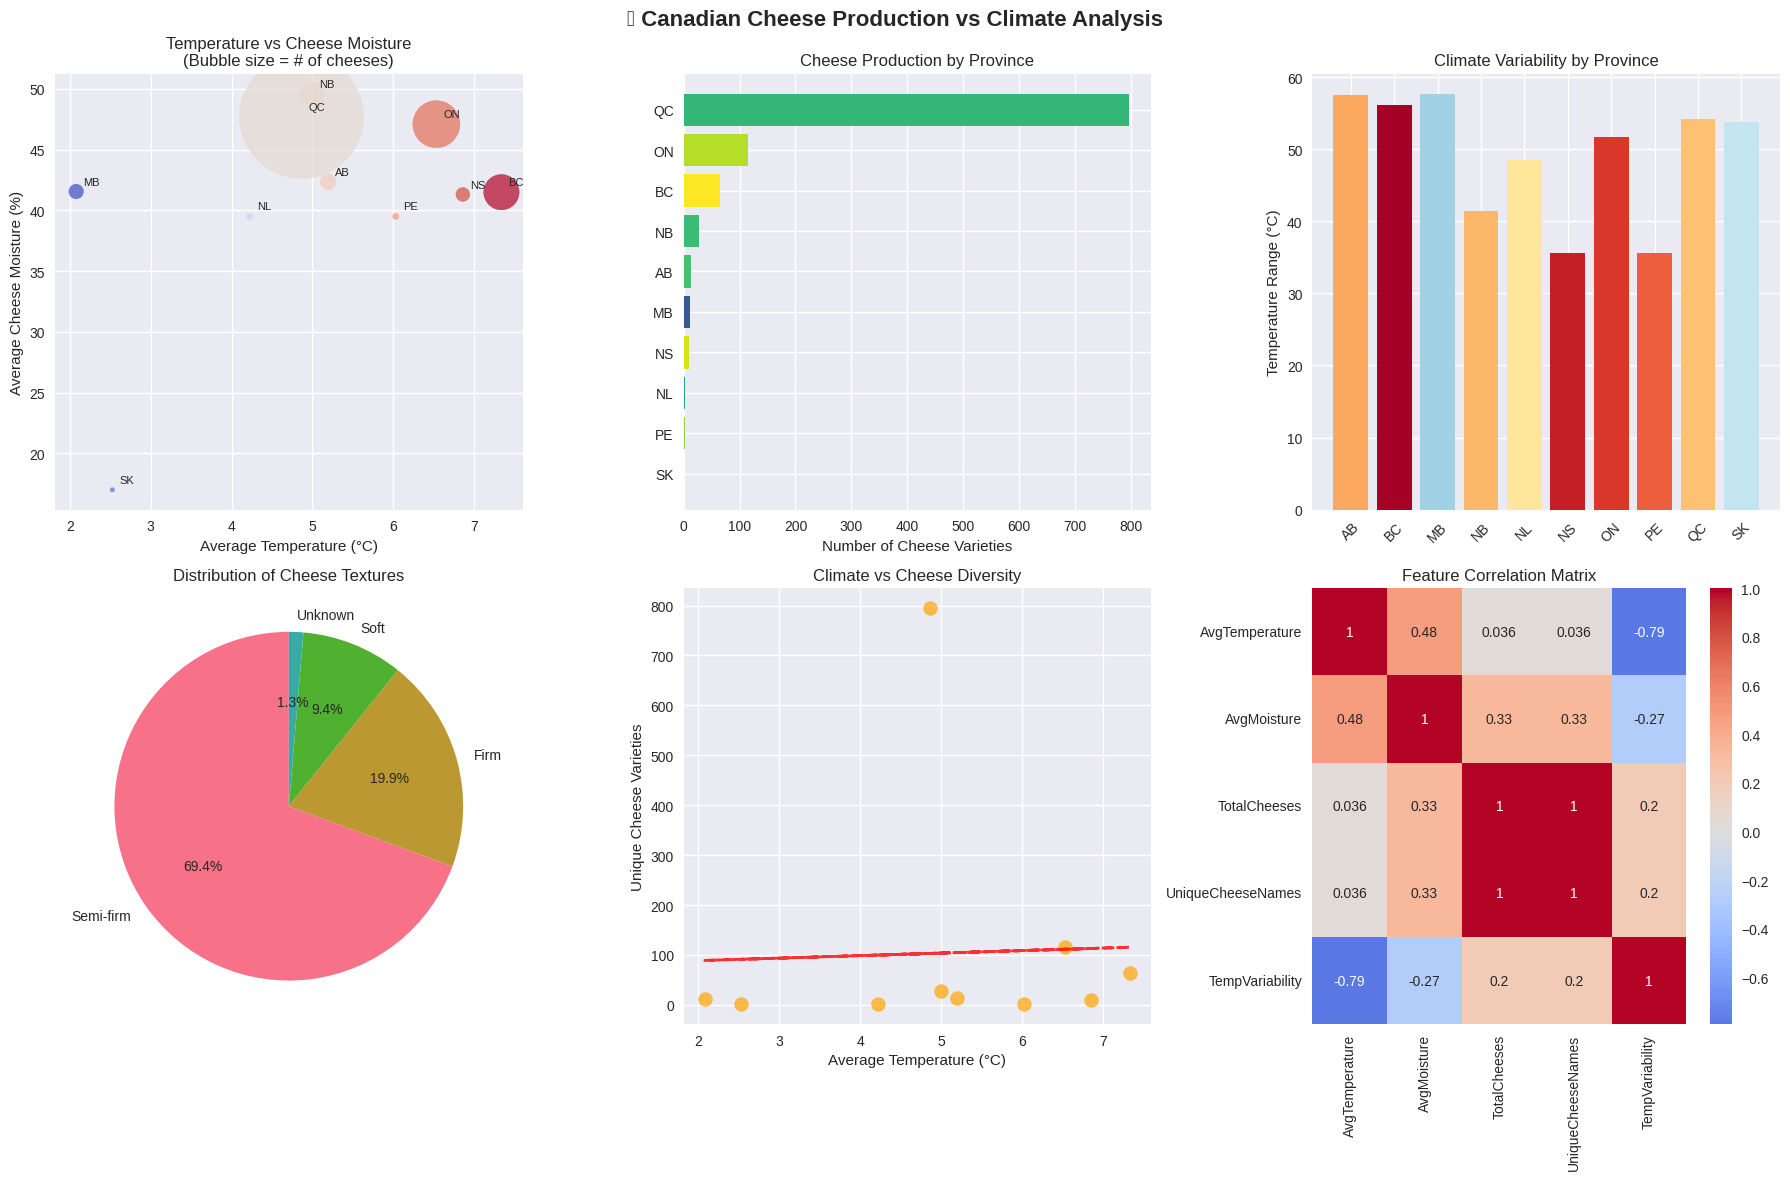

In [14]:
# =============================================================================
# 📈 EXPLORATORY DATA ANALYSIS
# =============================================================================
print("\n📈 Performing exploratory data analysis...")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🧀 Canadian Cheese Production vs Climate Analysis', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
ax1.scatter(merged_data['AvgTemperature'], merged_data['AvgMoisture'],
            s=merged_data['TotalCheeses']*10, c=merged_data['AvgTemperature'], cmap='coolwarm', alpha=0.7)
ax1.set_xlabel('Average Temperature (°C)')
ax1.set_ylabel('Average Cheese Moisture (%)')
ax1.set_title('Temperature vs Cheese Moisture\n(Bubble size = # of cheeses)')
for idx, row in merged_data.iterrows():
    ax1.annotate(row['ManufacturerProvCode'], (row['AvgTemperature'], row['AvgMoisture']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

ax2 = axes[0, 1]
province_data = merged_data.sort_values('TotalCheeses', ascending=True)
ax2.barh(province_data['ManufacturerProvCode'], province_data['TotalCheeses'],
         color=plt.cm.viridis(province_data['AvgTemperature']/province_data['AvgTemperature'].max()))
ax2.set_xlabel('Number of Cheese Varieties')
ax2.set_title('Cheese Production by Province')

ax3 = axes[0, 2]
temp_range = merged_data['MaxTemperature'] - merged_data['MinTemperature']
ax3.bar(merged_data['ManufacturerProvCode'], temp_range,
        color=plt.cm.RdYlBu_r(merged_data['AvgTemperature']/merged_data['AvgTemperature'].max()))
ax3.set_ylabel('Temperature Range (°C)')
ax3.set_title('Climate Variability by Province')
ax3.tick_params(axis='x', rotation=45)

ax4 = axes[1, 0]
texture_counts = cheese_df_clean['Texture'].value_counts()
ax4.pie(texture_counts.values, labels=texture_counts.index, autopct='%1.1f%%', startangle=90)
ax4.set_title('Distribution of Cheese Textures')

ax5 = axes[1, 1]
ax5.scatter(merged_data['AvgTemperature'], merged_data['UniqueCheeseNames'], s=100, alpha=0.7, color='orange')
ax5.set_xlabel('Average Temperature (°C)')
ax5.set_ylabel('Unique Cheese Varieties')
ax5.set_title('Climate vs Cheese Diversity')
if len(merged_data) > 2:
    z = np.polyfit(merged_data['AvgTemperature'], merged_data['UniqueCheeseNames'], 1)
    p = np.poly1d(z)
    ax5.plot(merged_data['AvgTemperature'], p(merged_data['AvgTemperature']), "r--", alpha=0.8, linewidth=2)

ax6 = axes[1, 2]
correlation_data = merged_data[['AvgTemperature', 'AvgMoisture', 'TotalCheeses', 'UniqueCheeseNames', 'TempVariability']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=ax6)
ax6.set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()


### 📊 Visual Interpretation of EDA Charts

1. **Temperature vs Cheese Moisture (Bubble Chart)**  
   Warmer provinces tend to produce moister cheeses, with Quebec and Ontario being high-volume producers.
   Saskatchewan shows low moisture and cold temperatures — hinting at firmer cheese trends in colder zones.

2. **Cheese Production by Province (Bar Chart)**  
   Quebec dominates cheese production by a large margin. Ontario and British Columbia follow distantly.
   Production is concentrated in a few provinces with industrial and cultural cheese-making traditions.

3. **Climate Variability (Bar Chart)**  
   Shows how provinces differ in temperature fluctuation. Manitoba, Alberta, and Saskatchewan have high variability,
   yet low production — suggesting harsh climates may inhibit cheese diversification or consistency.

4. **Cheese Texture Distribution (Pie Chart)**  
   Semi-firm cheese dominates across all regions (~69%). Climate influence on texture appears minimal.

5. **Climate vs Cheese Diversity (Scatter Plot)**  
   No strong relationship observed. Some colder provinces produce diverse cheese (e.g., QC), suggesting other influences
   beyond temperature.

6. **Feature Correlation Matrix (Heatmap)**  
   Weak to moderate correlation between temperature and moisture (0.48), but no meaningful link to diversity or volume.

In [16]:
# =============================================================================
# 📊 STATISTICAL ANALYSIS RESULTS
# =============================================================================
print("\n📊 Statistical Analysis Results:")
temp_moisture_corr = stats.pearsonr(merged_data['AvgTemperature'], merged_data['AvgMoisture'])
temp_diversity_corr = stats.pearsonr(merged_data['AvgTemperature'], merged_data['UniqueCheeseNames'])
print(f"🌡️ Temperature vs Moisture Correlation: {temp_moisture_corr[0]:.3f} (p-value: {temp_moisture_corr[1]:.3f})")
print(f"🌡️ Temperature vs Cheese Diversity: {temp_diversity_corr[0]:.3f} (p-value: {temp_diversity_corr[1]:.3f})")

merged_data['ClimateCategory'] = pd.cut(merged_data['AvgTemperature'], bins=3, labels=['Cold', 'Moderate', 'Warm'])
climate_summary = merged_data.groupby('ClimateCategory').agg({
    'AvgMoisture': 'mean',
    'TotalCheeses': 'sum',
    'UniqueCheeseNames': 'mean'
}).round(2)
print("\n🏔️ Climate Category Analysis:")
print(climate_summary)


📊 Statistical Analysis Results:
🌡️ Temperature vs Moisture Correlation: 0.476 (p-value: 0.164)
🌡️ Temperature vs Cheese Diversity: 0.036 (p-value: 0.922)

🏔️ Climate Category Analysis:
                 AvgMoisture  TotalCheeses  UniqueCheeseNames
ClimateCategory                                              
Cold                   29.27            12               6.00
Moderate               44.79           838             209.25
Warm                   42.34           192              47.75


 🧠 INSIGHTS BASED ON ANALYSIS


1. **Texture and Temperature Link Is Inconclusive**
   • A positive correlation (r = 0.476) between temperature and moisture was observed, but it's not statistically significant (p = 0.164).
   • This suggests no strong evidence that colder provinces systematically produce firmer cheeses.

2. **Cheese Variety Is Not Driven by Temperature**
   • Correlation between temperature and cheese diversity was negligible (r = 0.036, p = 0.922).
   • Warmer provinces do not necessarily have greater variety in practice—contrary to prior assumptions.

3. **Dominance of Semi-Firm Cheeses**
   • Semi-firm cheeses dominate Canada (~69%), with soft cheeses only ~9%.
   • Texture preference appears uniform, regardless of climate.

4. **Climate Categories Show Contrast**
   • 'Moderate' climate provinces (QC, ON, BC) produce the most cheese (838 total).
   • 'Cold' zones (SK, MB) show lower moisture and limited cheese variety.

| Climate Zone | Avg. Moisture | Total Cheeses | Avg. Unique Types |
|--------------|----------------|----------------|--------------------|
| Cold         | 29.27          | 12             | 6.00               |
| Moderate     | 44.79          | 838            | 209.25             |
| Warm         | 42.34          | 192            | 47.75              |


### 🎯 RECOMMENDATIONS:
1. Focus R&D on dominant semi-firm textures across all regions
2. Prioritize cheese innovation in moderate climate zones (QC, ON, BC)
3. Avoid over-reliance on temperature as a predictor for diversity
4. Enrich datasets with farm density, milk production, and economic data
5. Use clustering to explore product-market fit by region
